In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision  
import torchvision.transforms as transforms
from datetime import datetime
import pandas as pd
import os
from os.path import join
import timeitout_features
from tqdm import tqdmout_features
import numpy as npout_features
from sklearn.metrics import confusion_matrixout_features
from torch.utils.tensorboard import SummaryWriter
torch.cuda.is_available() 

True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def bce(y_preds, y_true, epsilon=np.finfo(np.float32).eps):
    return - (1-y_true)* torch.log(1-y_preds+epsilon) - y_true * torch.log(y_preds+epsilon)

In [4]:
def data_loader(data="train", directory=join(os.getcwd(),'NormalizedData.h5')):
    # Data types = train, validate, test
    print("[+] Loading Data..")
    tic=timeit.default_timer()

    df = pd.read_hdf(
                    directory,
                    key=data,
                    )
    
    toc=timeit.default_timer()
    print("[+] Data Loaded in", int(toc-tic), "seconds!")

    return df

In [5]:
def create_batch(df, size=200, debug=False):
    # Data types = train, validate, test

    if debug:
        print("[Info] Len(data) =", len(df))
        print("[Info] Len(data) / Batch Size =", len(df)/size)

    # Select the data size
    # TODO: Estou a perder um pouco de dados no final
    batch = iter([
            # Big tuple
            (
                i+1, # Batch number
                torch.tensor(df.iloc[x:x+size].drop(columns=['index','Name', 'Weights', 'Label']).values, dtype=torch.float32).to(device), # Features Removi MissingET_Eta porque tava cheio de NaA (???)
                torch.tensor(df['Label'].iloc[x:x+size].values, dtype=torch.float32).to(device),

                torch.tensor((
                np.where(
                    df['Label'].iloc[x:x+size] == 0,
                    df['Weights'].iloc[x:x+size] / df['Weights'].iloc[x:x+size][df['Label'].iloc[x:x+size] == 0].sum(),
                    df['Weights'].iloc[x:x+size] / df['Weights'].iloc[x:x+size][df['Label'].iloc[x:x+size] == 1].sum(),
                )
                * df['Label'].iloc[x:x+size].shape[0]
                / 2
                ), dtype=torch.float32).to(device),
                df.iloc[x:x+size]['Name'] #Nome
        ) 
        
         for i,x in enumerate(list(filter(lambda x: (x%(size+1) == 0) , [x for x in range(len(df))])))]) # Para size = 100 -> 0, 101, 202, 303, .. , 909, 1010, 1111


    del df

    return batch

In [6]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        features = 68
        self.layer1 = nn.Linear(in_features=features, out_features=256)
        self.layer2 = nn.Linear(in_features=256, out_features=256)
        """ self.layer3 = nn.Linear(in_features=500, out_features=500)
        self.layer4 = nn.Linear(in_features=500, out_features=500)
        self.layer5 = nn.Linear(in_features=500, out_features=200) """
        self.out = nn.Linear(in_features=256, out_features=1)

    def forward(self, t):


        t = self.layer1(t)
        t = F.relu(t)

        
        t = self.layer2(t)
        t = F.relu(t)


        t = self.out(t).to(device)
        # print(t.shape)

        t = torch.sigmoid(t)

        return t

Network = Network().to(device)


# Training Loop

In [8]:
#batch_number, features, target, weights, name 
train_data = data_loader(data='train')
val_data = data_loader(data='validate')


[+] Loading Data..
[+] Data Loaded in 7 seconds!
[+] Loading Data..
[+] Data Loaded in 2 seconds!


In [11]:
def train(train_data, val_data, batch_size = 256, epochs = 100, name=datetime.now().strftime("%d-%m-%Y_%H-%M-%S"), patience=10):
    optimizer = optim.Adam(Network.parameters(), lr=0.001)

    print("[+] Starting training..")
    tic=timeit.default_timer()

    # For early stopping
    patience_count = 0
    best_loss = 99999999999

    # Validation data prep.
    _, val_features, val_label, val_weights, _ = next(create_batch(val_data, size=val_data.shape[0]))
    del val_data

    for epoch in range(epochs):
        # Stop loop - Early stop
        if patience_count >= patience:
            print("Early Stoping break!", patience, "epochs without improvement.")
            break 

        # Tensorboard
        writer = SummaryWriter(log_dir=join(os.getcwd(), "TensorboardLogs", name))

        # Define variables
        
        total_loss = 0
        total_correct = 0

        # TIME!
        tic_e = timeit.default_timer()
        for batch in create_batch(train_data, size=batch_size):
            # batch -> (batch_number, Features, Label, Weights, Nome)


            preds = Network(batch[1]) # Passar a batch pela network

            ## Loss
            loss = bce(preds.squeeze(1), batch[2])
            loss = (batch[3] * loss) / batch[3].sum()
            loss = torch.mean(loss, dtype=torch.float32)


            optimizer.zero_grad() # Resetar gradientes
            loss.backward() # Calcular os gradientes
            optimizer.step()

            # Update metrics for batch
            total_loss += loss.item()
            total_correct += get_num_correct(preds, batch[2])


        # Validation Loss
        with torch.no_grad():
            val_loss = bce(Network(val_features).squeeze(1), val_label)
            val_loss = (val_weights * loss) / val_weights.sum()
            val_loss = torch.mean(val_loss, dtype=torch.float32)

        ## Tensorboard, metrics and callbacks
        # For every epoch, check if it's the best loss on the validation set to save the *best* model

        if val_loss.item() < best_loss:
            
            # Save the best model
            printout = "Best model yet!"

            best_loss = val_loss.item()
            
            torch.save(Network.state_dict(), join(os.getcwd(),"models",name))

            # Reset patience_count for early stop 
            patience_count = 0
        else:
            printout = ""
            # Increase patience_count for early stop (one epoch without improvement)
            patience_count += 1

        
        # Save metrics on the tensorboard logs
        writer.add_scalar('Total Correct', total_correct/train_data.shape[0], epoch)
        writer.add_scalar('Loss', total_loss, epoch)
        writer.add_scalar('Val Loss',val_loss, epoch)

        # TIME!
        toc_e = timeit.default_timer()
        print("Epoch", epoch, "| Total Correct:", total_correct/train_data.shape[0] , "| Loss:", total_loss,  "| Val Loss:", val_loss.item(), "| Time", int((toc_e-tic_e)), "seconds |", printout )

    # Final do treino
    toc=timeit.default_timer()

    print("[+] Training completed in", int((toc-tic)/60), "minutes!")

In [12]:
name=datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

train(train_data, val_data, name=name, epochs=500)
name

[+] Starting training..
Epoch 0 | Total Correct: 0.9522519829896879 | Loss: 5.419519945324282 | Val Loss: 2.330949433471119e-09 | Time 21 seconds | Best model yet!
Epoch 1 | Total Correct: 0.9522519829896879 | Loss: 5.067026061180513 | Val Loss: 1.5877614778503357e-09 | Time 20 seconds | Best model yet!
Epoch 2 | Total Correct: 0.9522519829896879 | Loss: 4.934206225676462 | Val Loss: 1.3728733705420382e-09 | Time 23 seconds | Best model yet!
Epoch 3 | Total Correct: 0.9522519829896879 | Loss: 4.795023772850982 | Val Loss: 1.1064863469911757e-09 | Time 21 seconds | Best model yet!
Epoch 4 | Total Correct: 0.9522519829896879 | Loss: 4.679422979708761 | Val Loss: 9.16902997971647e-10 | Time 20 seconds | Best model yet!
Epoch 5 | Total Correct: 0.9522519829896879 | Loss: 4.579642560755019 | Val Loss: 9.37795840982858e-10 | Time 20 seconds | 
Epoch 6 | Total Correct: 0.9522519829896879 | Loss: 4.4725878591270884 | Val Loss: 9.08740915850359e-10 | Time 23 seconds | Best model yet!
Epoch 7 | 

# Testing the model out

In [13]:
device = device = torch.device('cpu')
torch.set_grad_enabled(False)

In [14]:
Network = Network.to(device)
Network.load_state_dict(torch.load(join(os.getcwd(),"models",name)))

<All keys matched successfully>

In [15]:

Network.eval()

Network(
  (layer1): Linear(in_features=68, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

### Load Test Data

In [16]:
test_data = data_loader(data="test").drop(columns=['index'])
test_data.describe()

[+] Loading Data..
[+] Data Loaded in 2 seconds!


,Jet_Multi,Jet1_Mass,Jet1_Eta,Jet1_Phi,Jet1_PT,Jet1_BTag,Jet2_Mass,Jet2_Eta,Jet2_Phi,Jet2_PT,...,Muon1_Phi,Muon1_PT,Muon2_Eta,Muon2_Phi,Muon2_PT,MissingET_MET,MissingET_Phi,ScalarHT_HT,Label,Weights
count,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,...,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06
mean,-4.403962e-04,-3.169950e-04,1.919765e-03,-7.500912e-04,-2.182479e-03,-2.956233e-04,-1.920912e-03,-1.473976e-04,5.886514e-05,-1.119410e-03,...,1.310890e-03,-3.390498e-03,1.056866e-03,2.244645e-04,-2.551370e-03,-9.862976e-04,-5.075757e-04,-1.545192e-03,4.409513e-02,7.772088e-06
std,9.997421e-01,9.999649e-01,1.001273e+00,9.997466e-01,9.951093e-01,1.000060e+00,9.988197e-01,9.996049e-01,1.000510e+00,9.982385e-01,...,9.998913e-01,9.984771e-01,9.992862e-01,9.994316e-01,9.930162e-01,9.968513e-01,9.988965e-01,9.976698e-01,2.053065e-01,1.400269e-05
min,-1.649581e+00,-1.384238e+00,-3.538465e+00,-1.732104e+00,-1.227972e+00,-1.222218e+00,-1.458502e+00,-3.168550e+00,-1.795324e+00,-1.484852e+00,...,-1.999019e+00,-9.487765e-01,-3.067431e+00,-2.619935e+00,-6.540112e-01,-1.136653e+00,-1.731221e+00,-1.597308e+00,0.000000e+00,1.286454e-09
25%,-1.024832e+00,-5.923256e-01,-6.987161e-01,-8.670166e-01,-6.325989e-01,-1.222218e+00,-5.621344e-01,-6.583196e-01,-8.318531e-01,-6.321707e-01,...,-6.643602e-01,-9.487765e-01,6.259453e-04,2.053101e-04,-6.540112e-01,-7.578464e-01,-8.644043e-01,-6.779826e-01,0.000000e+00,1.811693e-07
50%,-4.000820e-01,-2.591055e-01,1.524748e-03,-1.526841e-03,-2.186928e-01,8.181844e-01,-1.839713e-01,-5.016521e-04,1.541433e-04,-1.812021e-01,...,7.188655e-04,-1.115985e-01,6.259453e-04,2.053101e-04,-6.540112e-01,-2.311350e-01,-1.250374e-03,-2.020433e-01,0.000000e+00,5.028781e-06
75%,8.494175e-01,2.696276e-01,7.022158e-01,8.662250e-01,3.497483e-01,8.181844e-01,3.662726e-01,6.576045e-01,8.318921e-01,4.305953e-01,...,6.678170e-01,3.632169e-01,6.259453e-04,2.053101e-04,5.261358e-01,4.865845e-01,8.641697e-01,4.270109e-01,0.000000e+00,7.089469e-06
max,7.096915e+00,4.129075e+01,3.513001e+00,1.731554e+00,3.008994e+01,8.181844e-01,3.596933e+01,3.166699e+00,1.795633e+00,3.140511e+01,...,2.000454e+00,3.957771e+01,3.068657e+00,2.620328e+00,3.332523e+01,3.837758e+01,1.731338e+00,2.017072e+01,1.000000e+00,8.083906e-05


In [17]:
test_label = torch.tensor(test_data['Label'].values, dtype=torch.float32).to(device)
test_predictions = Network(torch.tensor(test_data.drop(columns=['Label', 'Weights', 'Name']).values, dtype=torch.float32)).to(device)

In [18]:
confusion_matrix(test_predictions.round(), test_label)

array([[1314039,    9120],
       [ 129255,   57458]])

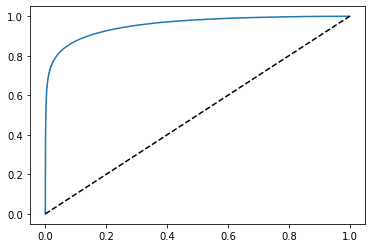

In [19]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# fpr = False positive rate
# tpr = True positive rate
fpr, tpr, thr = roc_curve(test_label , test_predictions, sample_weight=test_data["Weights"])
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_label , test_predictions, sample_weight=test_data["Weights"])

0.9551403101654902